In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

생성자

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim*4),
            self.gen_block(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
            self.gen_block(hidden_dim*2, hidden_dim),
            self.gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )
        
    def gen_block(self, in_channel, out_channel, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride),
                nn.Tanh(),
            )
        
    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)
    
    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

판별자

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.disc_block(im_chan, hidden_dim),
            self.disc_block(hidden_dim, hidden_dim*2),
            self.disc_block(hidden_dim*2, 1, final_layer=True),
        )
        
    def disc_block(self, in_, out, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_, out, kernel_size, stride),
                nn.BatchNorm2d(out),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_, out, kernel_size, stride)
            )
        
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

노이즈 생성

In [ ]:
def get_noise(n_samples, z_dim, device='cuda'):
    return torch.randn(n_samples, z_dim, device=device)

In [ ]:
# generator loss
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device) # z
    fake = gen(fake_noise) # G(z)
    disc_fake_pred = disc(fake) # D(G(z))
    # compare fake_pred & ones
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

In [ ]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, divice):
    fake_noise = get_noise(num_images, z_dim, device=device) # z
    fake = gen(fake_noise) # G(z)
    disc_fake_pred = disc(fake.detach()) # D(G(z))
    # compare fake_pred & zeros
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred)) # log(1-D(G(z)))
    disc_real_pred = disc(real)
    # compare real_pred & ones
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred)) # log(D(x))
    disc_loss = (disc_fake_loss + disc_real_loss)/2
    
    return disc_loss

image display

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1,28,28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1,2,0).squeeze())
    plt.show()

초기화

In [ ]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 256
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

데이터 로딩

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
])


dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
    )

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


초기화

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 500: Generator loss: 0.8759892451763149, discriminator loss: 0.5196201001405717


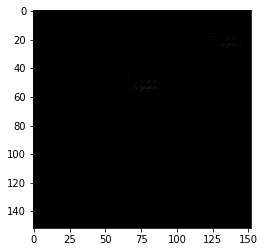

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


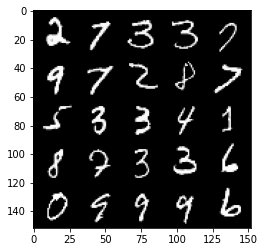

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 1000: Generator loss: 2.2418151128292085, discriminator loss: 0.14099109306186436


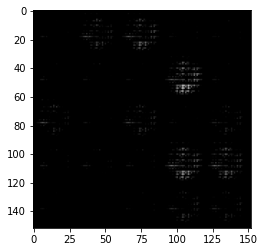

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


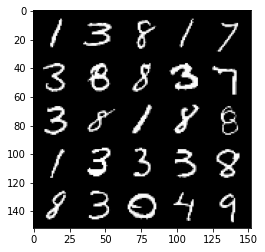

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 1500: Generator loss: 2.36515590953827, discriminator loss: 0.2502288971990348


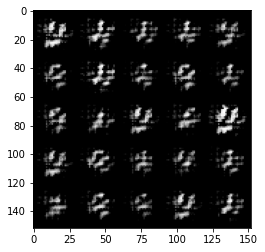

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


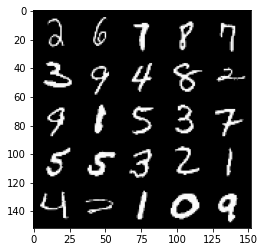

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 2000: Generator loss: 1.490449688971041, discriminator loss: 0.4217107308208939


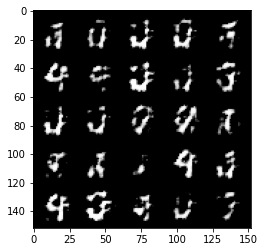

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


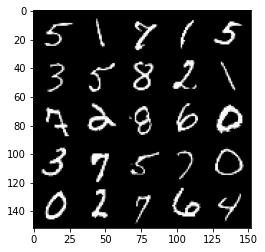

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 2500: Generator loss: 1.1867788207829004, discriminator loss: 0.49197295540571245


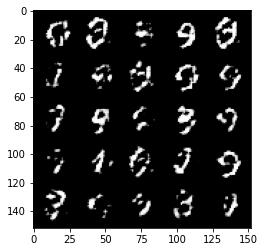

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


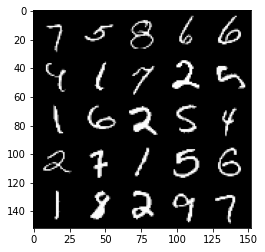

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 3000: Generator loss: 0.9509582820832733, discriminator loss: 0.5795004079937931


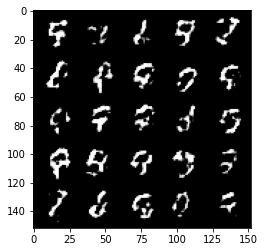

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


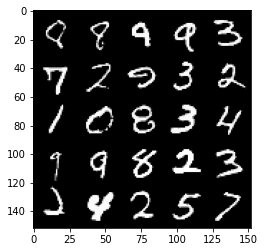

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 3500: Generator loss: 0.8346773459911342, discriminator loss: 0.6349658330678934


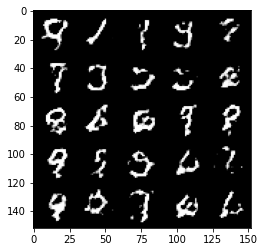

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


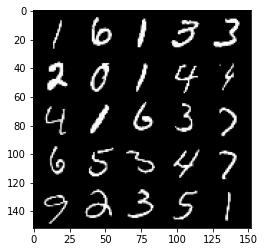

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 4000: Generator loss: 0.8091048420667645, discriminator loss: 0.6533350661993027


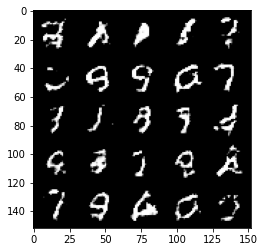

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


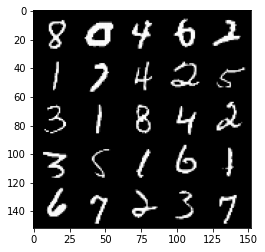

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 4500: Generator loss: 0.7898561603426931, discriminator loss: 0.6680781625509264


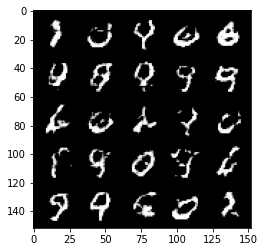

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


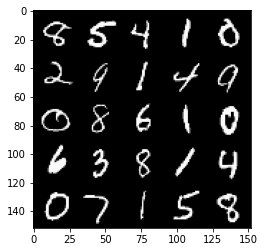

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 5000: Generator loss: 0.7549128974080075, discriminator loss: 0.6709404004812236


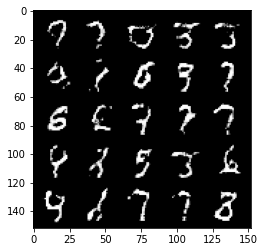

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


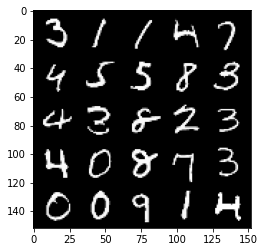

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 5500: Generator loss: 0.7595197516679766, discriminator loss: 0.6777527550458906


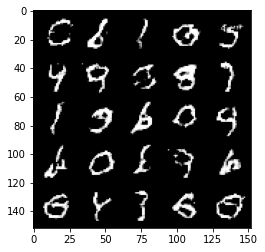

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


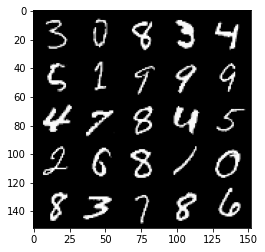

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 6000: Generator loss: 0.7501707350015637, discriminator loss: 0.6793351473808292


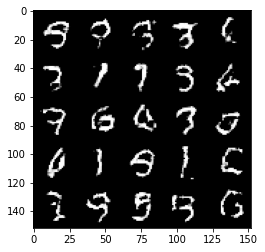

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


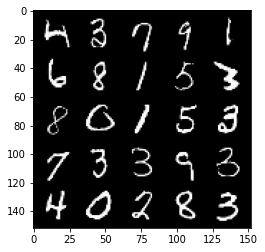

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 6500: Generator loss: 0.7470915421247479, discriminator loss: 0.6800748734474176


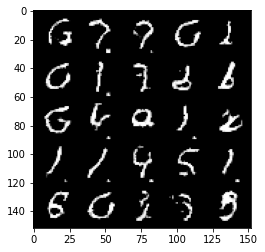

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


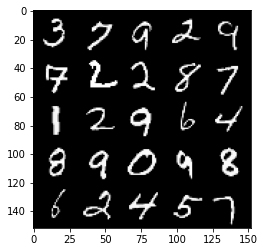

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 7000: Generator loss: 0.7454131336212161, discriminator loss: 0.6843974391222003


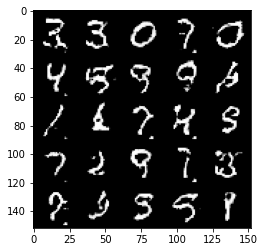

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


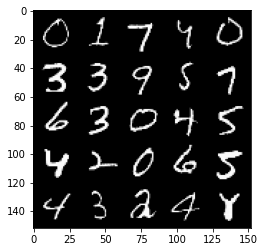

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 7500: Generator loss: 0.7344529958963392, discriminator loss: 0.684875643968582


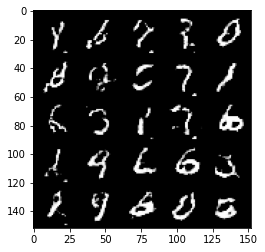

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


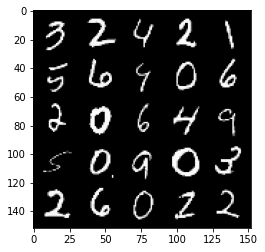

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 8000: Generator loss: 0.7384111227989202, discriminator loss: 0.6872633974552154


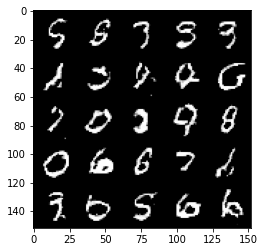

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


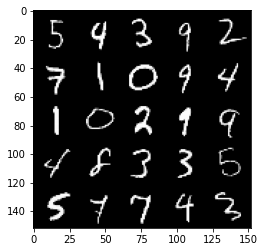

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 8500: Generator loss: 0.7359461692571628, discriminator loss: 0.6895326871871951


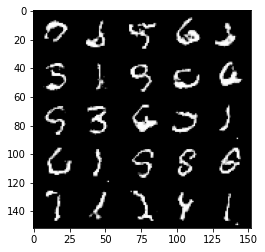

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


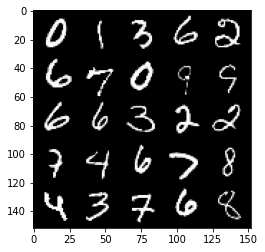

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 9000: Generator loss: 0.7278605034947393, discriminator loss: 0.6919588170051575


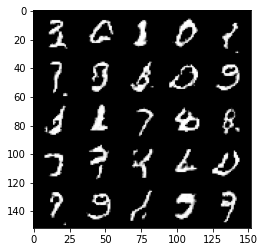

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


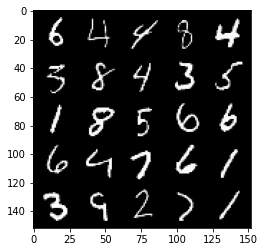

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 9500: Generator loss: 0.7272312418222427, discriminator loss: 0.692191778063774


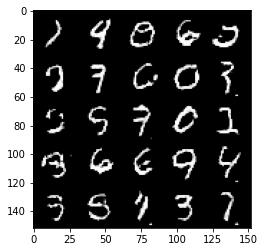

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


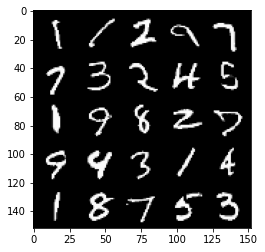

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 10000: Generator loss: 0.7249158638715741, discriminator loss: 0.6934005169868473


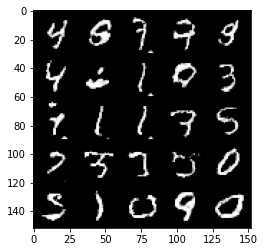

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


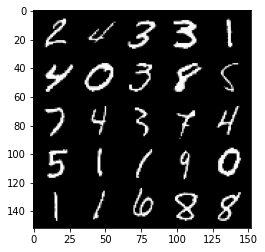

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 10500: Generator loss: 0.7221085636615744, discriminator loss: 0.6946222795248032


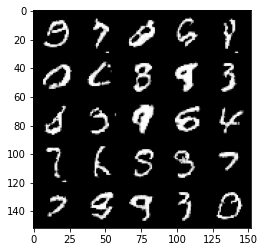

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


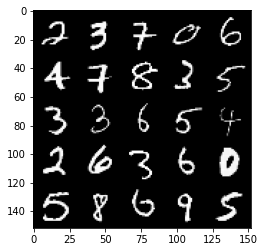

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 11000: Generator loss: 0.7174893388748164, discriminator loss: 0.6966683460474015


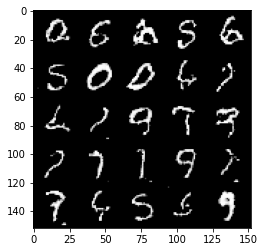

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


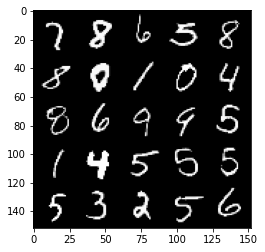

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 11500: Generator loss: 0.7195195832252509, discriminator loss: 0.6964345295429227


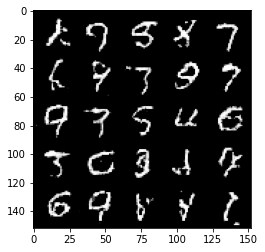

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


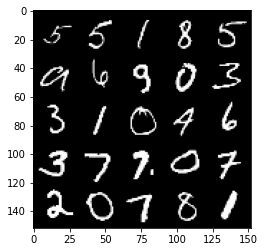

In [ ]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        
        # upgrade discriminator
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        
        # track the average disc loss
        mean_discriminator_loss += disc_loss.item() / display_step
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        # update generator
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        # track the average gen loss
        mean_generator_loss += gen_loss.item() / display_step

#         if test_generator:
#             try:
#                 assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch ==0)
#                 assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
#             except:
#                 error=True
#                 print("Runtime tests have failed")

        # visualize the results
    
        if cur_step % display_step == 0 and cur_step >0:
            print(f"step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
                                  

In [ ]:
fake.shape

torch.Size([128, 1, 34, 34])

In [ ]:
fake_noise = get_noise(128, z_dim, device=device)
# fake = gen(fake_noise)

In [ ]:
fake_noise.shape

torch.Size([128, 64])

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
fake = gen(fake_noise)

In [ ]:
fake.shape

torch.Size([128, 1, 34, 34])